Importing a dataset: downloading a CSV file from Azure blob storage and saving it in this notebook:

curl is a Bash command. You can execute Bash commands in a Jupyter notebook by prefixing them with an exclamation mark. This command downloads a CSV file from Azure blob storage and saves it using the name flightdata.csv.

In [1]:
!curl https://topcs.blob.core.windows.net/public/FlightData.csv -o flightdata.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1552k  100 1552k    0     0   974k      0  0:00:01  0:00:01 --:--:--  984k


Loading flightdata.csv, creating a Pandas DataFrame from it, and displaing the first five rows:

In [2]:
import pandas as pd

df = pd.read_csv('flightdata.csv')
df.head()

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,TAIL_NUM,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,...,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DEL15,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,Unnamed: 25
0,2016,1,1,1,5,DL,N836DN,1399,10397,ATL,...,2143,2102.0,-41.0,0.0,0.0,0.0,338.0,295.0,2182.0,NaN
1,2016,1,1,1,5,DL,N964DN,1476,11433,DTW,...,1435,1439.0,4.0,0.0,0.0,0.0,110.0,115.0,528.0,NaN
2,2016,1,1,1,5,DL,N813DN,1597,10397,ATL,...,1215,1142.0,-33.0,0.0,0.0,0.0,335.0,300.0,2182.0,NaN
3,2016,1,1,1,5,DL,N587NW,1768,14747,SEA,...,1335,1345.0,10.0,0.0,0.0,0.0,196.0,205.0,1399.0,NaN
4,2016,1,1,1,5,DL,N836DN,1823,14747,SEA,...,607,615.0,8.0,0.0,0.0,0.0,247.0,259.0,1927.0,NaN


Loading the dataset:

The DataFrame created above contains on-time arrival information for a major U.S. airline. It has more than 11,000 rows and 26 columns. (The output says "5 rows" because DataFrame's head function only returns the first five rows.) Each row represents one flight and contains information such as the origin, the destination, the scheduled departure time, and whether the flight arrived on time or late.

Counting the rows and columns:

One of the first things we typically want to know about a dataset is how many rows and columns it contains.

In [3]:
df.shape

(11231, 26)

This DataFrame contains 11,231 rows and 26 columns

The dataset includes a roughly even distribution of dates throughout the year, which is important because a flight out of Minneapolis is less likely to be delayed due to winter storms in July than it is in January. But this dataset is far from being "clean" and ready to use. Let's write some Pandas code to clean it up.

One of the most important aspects of preparing a dataset for use in machine learning is selecting the "feature" columns that are relevant to the outcome we are trying to predict while filtering out columns that do not affect the outcome, could bias it in a negative way, or might produce multicollinearity. Another important task is to eliminate missing values, either by deleting the rows or columns containing them or replacing them with meaningful values. In this exercise, we will eliminate extraneous columns and replace missing values in the remaining columns.

Checking for missing values in Pandas:

In [4]:
df.isnull().values.any()

True

"True" indicates that there is at least one missing value somewhere in the datase.

Finding out where the missing values are:

In [5]:
df.isnull().sum()

YEAR                       0
QUARTER                    0
MONTH                      0
DAY_OF_MONTH               0
DAY_OF_WEEK                0
UNIQUE_CARRIER             0
TAIL_NUM                   0
FL_NUM                     0
ORIGIN_AIRPORT_ID          0
ORIGIN                     0
DEST_AIRPORT_ID            0
DEST                       0
CRS_DEP_TIME               0
DEP_TIME                 107
DEP_DELAY                107
DEP_DEL15                107
CRS_ARR_TIME               0
ARR_TIME                 115
ARR_DELAY                188
ARR_DEL15                188
CANCELLED                  0
DIVERTED                   0
CRS_ELAPSED_TIME           0
ACTUAL_ELAPSED_TIME      188
DISTANCE                   0
Unnamed: 25            11231
dtype: int64

Curiously, the 26th column ("Unnamed: 25") contains 11,231 missing values, which equals the number of rows in the dataset. This column was mistakenly created because the CSV file that we imported contains a comma at the end of each line. To eliminate that column, we add the following code to the notebook and execute it:

In [6]:
df = df.drop('Unnamed: 25', axis=1)
df.isnull().sum()

YEAR                     0
QUARTER                  0
MONTH                    0
DAY_OF_MONTH             0
DAY_OF_WEEK              0
UNIQUE_CARRIER           0
TAIL_NUM                 0
FL_NUM                   0
ORIGIN_AIRPORT_ID        0
ORIGIN                   0
DEST_AIRPORT_ID          0
DEST                     0
CRS_DEP_TIME             0
DEP_TIME               107
DEP_DELAY              107
DEP_DEL15              107
CRS_ARR_TIME             0
ARR_TIME               115
ARR_DELAY              188
ARR_DEL15              188
CANCELLED                0
DIVERTED                 0
CRS_ELAPSED_TIME         0
ACTUAL_ELAPSED_TIME    188
DISTANCE                 0
dtype: int64

The DataFrame still contains a lot of missing values, but some of them aren't useful because the columns containing them are not relevant to the model that we are building. The goal of that model is to predict whether a flight we are considering booking is likely to arrive on time. If you know that the flight is likely to be late, you might choose to book another flight.

Filtering the dataset to eliminate columns that are not relevant to a predictive model:

For example, the aircraft's tail number probably has little bearing on whether a flight will arrive on time, and at the time you book a ticket, you have no way of knowing whether a flight will be cancelled, diverted, or delayed.

By contrast, the scheduled departure time could have a lot to do with on-time arrivals. Because of the hub-and-spoke system used by most airlines, morning flights tend to be on time more often than afternoon or evening flights.

At some major airports, traffic stacks up during the day, increasing the likelihood that later flights will be delayed.

Pandas provides an easy way to filter out columns we do not want with following code:

In [7]:
df = df[["MONTH", "DAY_OF_MONTH", "DAY_OF_WEEK", "ORIGIN", "DEST", "CRS_DEP_TIME", "ARR_DEL15"]]
df.isnull().sum()

MONTH             0
DAY_OF_MONTH      0
DAY_OF_WEEK       0
ORIGIN            0
DEST              0
CRS_DEP_TIME      0
ARR_DEL15       188
dtype: int64

The output shows that the DataFrame now includes only the columns that are relevant to the model, and that the number of missing values is greatly reduced.

The only column that now contains missing values is the ARR_DEL15 column, which uses 0s to identify flights that arrived on time and 1s for flights that didn't.

We use the following code to show the first five rows with missing values:

In [8]:
df[df.isnull().values.any(axis=1)].head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_DEP_TIME,ARR_DEL15
177,1,9,6,MSP,SEA,701,NaN
179,1,10,7,MSP,DTW,1348,NaN
184,1,10,7,MSP,DTW,625,NaN
210,1,10,7,DTW,MSP,1200,NaN
478,1,22,5,SEA,JFK,2305,NaN


Pandas represents missing values with NaN, which stands for Not a Number. The output shows that these rows are indeed missing values in the ARR_DEL15 column.

The reason these rows are missing ARR_DEL15 values is that they all correspond to flights that were canceled or diverted. We could call dropna on the DataFrame to remove these rows. However since a flight that is canceled or diverted to another airport could be considered "late," let's use the fillna method to replace the missing values with 1s:

Replacing missing values in the ARR_DEL15 column with 1s and display rows 177 through 184:

In [9]:
df = df.fillna({'ARR_DEL15': 1})
df.iloc[177:185]

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_DEP_TIME,ARR_DEL15
177,1,9,6,MSP,SEA,701,1.0
178,1,9,6,DTW,JFK,1527,0.0
179,1,10,7,MSP,DTW,1348,1.0
180,1,10,7,DTW,MSP,1540,0.0
181,1,10,7,JFK,ATL,1325,0.0
182,1,10,7,JFK,ATL,610,0.0
183,1,10,7,JFK,SEA,1615,0.0
184,1,10,7,MSP,DTW,625,1.0


The dataset is now "clean" in the sense that missing values have been replaced and the list of columns has been narrowed to those most relevant to the model. But we are not finished yet.

There is more to do to prepare the dataset for use in machine learning.

The CRS_DEP_TIME column of the dataset we are using represents scheduled departure times.

The granularity of the numbers in this column — it contains more than 500 unique values — could have a negative impact on accuracy in a machine-learning model.

This can be resolved using a technique called binning or quantization. What if you divided each number in this column by 100 and rounded down to the nearest integer? 1030 would become 10, 1925 would become 19, and so on, and you would be left with a maximum of 24 discrete values in this column.

Intuitively, it makes sense, because it probably doesn't matter much whether a flight leaves at 10:30 a.m. or 10:40 a.m. It matters a great deal whether it leaves at 10:30 a.m. or 5:30 p.m.

In addition, the dataset's ORIGIN and DEST columns contain airport codes that represent categorical machine-learning values. These columns need to be converted into discrete columns containing indicator variables, sometimes known as "dummy" variables. In other words, the ORIGIN column, which contains five airport codes, needs to be converted into five columns, one per airport, with each column containing 1s and 0s indicating whether a flight originated at the airport that the column represents.

The DEST column needs to be handled in a similar manner.

In the following exercises, we will "bin" the departure times in the CRS_DEP_TIME column and use Pandas' get_dummies method to create indicator columns from the ORIGIN and DEST columns:

Displaying the first five rows of the DataFrame:

In [10]:
df.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_DEP_TIME,ARR_DEL15
0,1,1,5,ATL,SEA,1905,0.0
1,1,1,5,DTW,MSP,1345,0.0
2,1,1,5,ATL,SEA,940,0.0
3,1,1,5,SEA,MSP,819,0.0
4,1,1,5,SEA,DTW,2300,0.0


The above was the DataFrame with unbinned departure times.

Using the following statements to bin the departure times:

In [11]:
import math

for index, row in df.iterrows():
    df.loc[index, 'CRS_DEP_TIME'] = math.floor(row['CRS_DEP_TIME'] / 100)
df.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_DEP_TIME,ARR_DEL15
0,1,1,5,ATL,SEA,19,0.0
1,1,1,5,DTW,MSP,13,0.0
2,1,1,5,ATL,SEA,9,0.0
3,1,1,5,SEA,MSP,8,0.0
4,1,1,5,SEA,DTW,23,0.0


Above: the DataFrame with binned departure times.

A better way to loop through rows, if loop you must, is with the iterrows() method. iterrows() is a generator that iterates over the rows of the dataframe and returns the index of each row, in addition to an object containing the row itself

In Pandas, the loc() function is used to access a group of rows and columns by label(s) or a boolean array. . loc[] is primarily label based, but may also be used with a boolean array

The python math. floor function is used to return the closest integer value which is less than or equal to the specified expression or Value

Using the following statements to generate indicator columns from the ORIGIN and DEST columns, while dropping the ORIGIN and DEST columns themselves:

In [12]:
df = pd.get_dummies(df, columns=['ORIGIN', 'DEST'])
df.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,CRS_DEP_TIME,ARR_DEL15,ORIGIN_ATL,ORIGIN_DTW,ORIGIN_JFK,ORIGIN_MSP,ORIGIN_SEA,DEST_ATL,DEST_DTW,DEST_JFK,DEST_MSP,DEST_SEA
0,1,1,5,19,0.0,1,0,0,0,0,0,0,0,0,1
1,1,1,5,13,0.0,0,1,0,0,0,0,0,0,1,0
2,1,1,5,9,0.0,1,0,0,0,0,0,0,0,0,1
3,1,1,5,8,0.0,0,0,0,0,1,0,0,0,1,0
4,1,1,5,23,0.0,0,0,0,0,1,0,1,0,0,0


The get_dummies() function is used to convert categorical variable into dummy/indicator variables. Syntax: pandas.get_dummies(data, prefix=None, prefix_sep='_', dummy_na=False, columns=None, sparse=False, drop_first=False, dtype=None)

In the above resulting DataFrame the ORIGIN and DEST columns were replaced with columns corresponding to the airport codes present in the original columns. The new columns have 1s and 0s indicating whether a given flight originated at or was destined for the corresponding airport.

Above: the DataFrame with indicator columns

The dataset is now optimized for use in machine learning.

To create a machine learning model, we need two datasets: one for training and one for testing. 

In practice, we often have only one dataset, so we split it into two.

In this exercise, we will perform an 80-20 split on the DataFrame you prepared in the previous lab so we can use it to train a machine learning model.

We will also separate the DataFrame into feature columns and label columns.

The former contains the columns used as input to the model (for example, the flight's origin and destination and the scheduled departure time)

While the latter contains the column that the model will attempt to predict — in this case, the ARR_DEL15 column, which indicates whether a flight will arrive on time.

In [13]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(df.drop('ARR_DEL15', axis=1), df['ARR_DEL15'], test_size=0.2, random_state=42)

The first statement imports scikit-learn's train_test_split helper function. The second line uses the function to split the DataFrame into a training set containing 80% of the original data, and a test set containing the remaining 20%. The random_state parameter seeds the random-number generator used to do the splitting, while the first and second parameters are DataFrames containing the feature columns and the label column.

sklearn.model_selection.train_test_split

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

To drop columns, we can use .drop

df1 = df.drop(columns="cabin")

train_test_split returns four DataFrames. We use the following command to display the number of rows and columns in the DataFrame containing the feature columns used for training:

In [14]:
train_x.shape

(8984, 14)

Now we use the command below to display the number of rows and columns in the DataFrame containing the feature columns used for testing:

In [15]:
test_x.shape

(2247, 14)

There are many types of machine learning models.

One of the most common is the regression model, which uses one of a number of regression algorithms to produce a numeric value — for example, a person's age or the probability that a credit-card transaction is fraudulent.

We will train a classification model, which seeks to resolve a set of inputs into one of a set of known outputs.

A classic example of a classification model is one that examines e-mails and classifies them as "spam" or "not spam."

Our model will be a binary classification model that predicts whether a flight will arrive on-time or late ("binary" because there are only two possible outputs).

One of the benefits of using scikit-learn is that you don't have to build these models — or implement the algorithms that they use — by hand.

Scikit-learn includes a variety of classes for implementing common machine learning models. One of them is RandomForestClassifier, which fits multiple decision trees to the data and uses averaging to boost the overall accuracy and limit overfitting.

3.2.4.3.1. sklearn.ensemble.RandomForestClassifier:
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

The following code will create a RandomForestClassifier object and train it by calling the fit method:

In [16]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=13)
model.fit(train_x, train_y)

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=13, verbose=0, warm_start=False)

fit(self, X, y, sample_weight=None)
=> https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.fit

The output shows the parameters used in the classifier, including n_estimators, which specifies the number of trees in each decision-tree forest, and max_depth, which specifies the maximum depth of the decision trees. The values shown are the defaults, but you can override any of them when creating the RandomForestClassifier object.

Calling the predict method to test the model using the values in test_x, followed by the score method to determine the mean accuracy of the model:

In [17]:
predicted = model.predict(test_x)
model.score(test_x, test_y)

0.8602581219403649

The mean accuracy is 86%, which seems good on the surface. However, mean accuracy isn't always a reliable indicator of the accuracy of a classification model. Let's dig a little deeper and determine how accurate the model really is — that is, how adept it is at determining whether a flight will arrive on time.

There are several ways to measure the accuracy of a classification model. One of the best overall measures for a binary classification model is Area Under Receiver Operating Characteristic Curve (sometimes referred to as "ROC AUC"), which essentially quantifies how often the model will make a correct prediction regardless of the outcome. In this unit, you'll compute an ROC AUC score for the model you built previously and learn about some of the reasons why that score is lower than the mean accuracy output by the score method. You'll also learn about other ways to gauge the accuracy of the model.

Before we compute the ROC AUC, we must generate prediction probabilities for the test set. These probabilities are estimates for each of the classes, or answers, the model can predict. For example, [0.88199435, 0.11800565] means that there's an 89% chance that a flight will arrive on time (ARR_DEL15 = 0) and a 12% chance that it won't (ARR_DEL15 = 1). The sum of the two probabilities adds up to 100%.

Running the following code will generate a set of prediction probabilities from the test data:

In [18]:
from sklearn.metrics import roc_auc_score
probabilities = model.predict_proba(test_x)

Using the following statement to generate an ROC AUC score from the probabilities using scikit-learn's roc_auc_score method:

In [19]:
roc_auc_score(test_y, probabilities[:,1])

0.6743824904998539

Question: why is the AUC score lower than the mean accuracy computed in the previous exercise?

The output from the score method reflects how many of the items in the test set the model predicted correctly. This score is skewed by the fact that the dataset the model was trained and tested with many more rows representing on-time arrivals than rows representing late arrivals. Because of this imbalance in the data, you're more likely to be correct if you predict that a flight will be on time than if you predict that a flight will be late.

ROC AUC takes this into account and provides a more accurate indication of how likely it is that a prediction of on-time or late will be correct.

We can learn more about the model's behavior by generating a confusion matrix, also known as an error matrix. The confusion matrix quantifies the number of times each answer was classified correctly or incorrectly. Specifically, it quantifies the number of false positives, false negatives, true positives, and true negatives. This is important, because if a binary classification model trained to recognize cats and dogs is tested with a dataset that is 95% dogs, it could score 95% simply by guessing "dog" every time. But if it failed to identify cats at all, it would be of little value.

Producing a confusion matrix for our model:

In [20]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_y, predicted)

array([[1882,   54],
       [ 260,   51]])

But look at the second row, which represents flights that were delayed. The first column shows how many delayed flights were incorrectly predicted to be on time. The second column shows how many flights were correctly predicted to be delayed. Clearly, the model isn't nearly as adept at predicting that a flight will be delayed as it is at predicting that a flight will arrive on time. What you want in a confusion matrix is large numbers in the upper-left and lower-right corners, and small numbers (preferably zeros) in the upper-right and lower-left corners.

Other measures of accuracy for a classification model include precision and recall. Suppose the model was presented with three on-time arrivals and three delayed arrivals, and that it correctly predicted two of the on-time arrivals, but incorrectly predicted that two of the delayed arrivals would be on time. In this case, the precision would be 50% (two of the four flights it classified as being on time actually were on time), while its recall would be 67% (it correctly identified two of the three on-time arrivals). You can learn more about precision and recall from https://en.wikipedia.org/wiki/Precision_and_recall

Scikit-learn contains a handy method named precision_score for computing precision. 
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html

To quantify the precision of our model, let's execute the following statements:

In [21]:
from sklearn.metrics import precision_score

train_predictions = model.predict(train_x)
precision_score(train_y, train_predictions)

0.9972375690607734

Scikit-learn also contains a method named recall_score for computing recall. To measure our model's recall,  let's execute the following statements:

In [22]:
from sklearn.metrics import recall_score
recall_score(train_y, train_predictions)

0.8650159744408946

In the real world, a trained data scientist would look for ways to make the model even more accurate. Among other things, they would try different algorithms and take steps to tune the chosen algorithm to find the optimum combination of parameters. Another likely step would be to expand the dataset to millions of rows rather than a few thousand and also attempt to reduce the imbalance between late and on-time arrivals. But for our purposes, the model is fine as-is.

Next is unit 5 of 6 => Exercise - Visualize Output of Model

# Importing Matplotlib into this notebook and configuring the notebook to support inline Matplotlib output

Ignore any warning messages that are displayed related to font caching:

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

The first statement is one of several magic commands supported by the Python kernel that we selected when we created the notebook. It enables Jupyter to render Matplotlib output in a notebook without making repeated calls to show. And it must appear before any references to Matplotlib itself. The final statement configures Seaborn to enhance the output from Matplotlib.

Built-in magic commands (%)
https://ipython.readthedocs.io/en/stable/interactive/magics.html

matplotlib.pyplot.show
https://matplotlib.org/devdocs/api/_as_gen/matplotlib.pyplot.show.html

seaborn: statistical data visualization
https://seaborn.pydata.org

# Matplotlib at work: plotting the ROC curve for the machine-learning model we built in the previous lab

Text(0, 0.5, 'True Positive Rate')

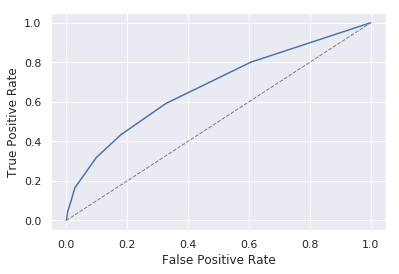

In [24]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(test_y, probabilities[:, 1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

The dotted line in the middle of the graph represents a 50-50 chance of obtaining a correct answer. The blue curve represents the accuracy of your model.

The reason we built a machine-learning model is to predict whether a flight will arrive on time or late. In this exercise, we'll write a Python function that calls the machine-learning model you built in the previous lab to compute the likelihood that a flight will be on time. Then you'll use the function to analyze several flights.

In [27]:
def predict_delay(departure_date_time, origin, destination):
    from datetime import datetime

    try:
        departure_date_time_parsed = datetime.strptime(departure_date_time, '%d/%m/%Y %H:%M:%S')
    except ValueError as e:
        return 'Error parsing date/time - {}'.format(e)

    month = departure_date_time_parsed.month
    day = departure_date_time_parsed.day
    day_of_week = departure_date_time_parsed.isoweekday()
    hour = departure_date_time_parsed.hour

    origin = origin.upper()
    destination = destination.upper()

    input = [{'MONTH': month,
              'DAY': day,
              'DAY_OF_WEEK': day_of_week,
              'CRS_DEP_TIME': hour,
              'ORIGIN_ATL': 1 if origin == 'ATL' else 0,
              'ORIGIN_DTW': 1 if origin == 'DTW' else 0,
              'ORIGIN_JFK': 1 if origin == 'JFK' else 0,
              'ORIGIN_MSP': 1 if origin == 'MSP' else 0,
              'ORIGIN_SEA': 1 if origin == 'SEA' else 0,
              'DEST_ATL': 1 if destination == 'ATL' else 0,
              'DEST_DTW': 1 if destination == 'DTW' else 0,
              'DEST_JFK': 1 if destination == 'JFK' else 0,
              'DEST_MSP': 1 if destination == 'MSP' else 0,
              'DEST_SEA': 1 if destination == 'SEA' else 0 }]

    return model.predict_proba(pd.DataFrame(input))[0][0]

This function takes as input a date and time, an origin airport code, and a destination airport code, and returns a value between 0.0 and 1.0 indicating the probability that the flight will arrive at its destination on time. It uses the machine-learning model we built in the previous lab to compute the probability. And to call the model, it passes a DataFrame containing the input values to predict_proba. The structure of the DataFrame exactly matches the structure of the DataFrame we used earlier.

Note:

Date input to the predict_delay function use the international date format dd/mm/year.

With the code below, we will compute the probability that a flight from New York to Atlanta on the evening of October 1 will arrive on time. The year is irrelevant because it isn't used by the model.

In [32]:
# date format dd/mm/year.

predict_delay('1/10/2018 21:45:00', 'JFK', 'ATL')

0.6

The output shows that the likelihood of an on-time arrival is 60%

Modifing the code to compute the probability that the same flight a day later will arrive on time:

In [33]:
# date format dd/mm/year.

predict_delay('2/10/2018 21:45:00', 'JFK', 'ATL')

0.8

The output shows that the likelihood of an on-time arrival is 80%

If your travel plans were flexible, would you consider postponing your trip for one day? The likelihood will change from 60% to 80%

Modifing the code to compute the probability that a morning flight the same day from Atlanta to Seattle will arrive on time:

In [34]:
predict_delay('2/10/2018 10:00:00', 'ATL', 'SEA')

1.0

We now have an easy way to predict, with a single line of code, whether a flight is likely to be on time or late. Keep in mind that the results are only meaningful for the airport codes ATL, DTW, JFK, MSP, and SEA because those are the only airport codes the model was trained with.

Executing the following code to plot the probability of on-time arrivals for an evening flight from JFK to ATL over a range of days:

(0.0, 1.0)

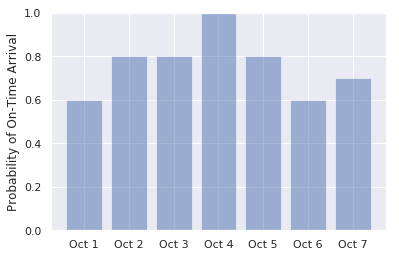

In [35]:
import numpy as np

labels = ('Oct 1', 'Oct 2', 'Oct 3', 'Oct 4', 'Oct 5', 'Oct 6', 'Oct 7')
values = (predict_delay('1/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('2/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('3/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('4/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('5/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('6/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('7/10/2018 21:45:00', 'JFK', 'ATL'))
alabels = np.arange(len(labels))

plt.bar(alabels, values, align='center', alpha=0.5)
plt.xticks(alabels, labels)
plt.ylabel('Probability of On-Time Arrival')
plt.ylim((0.0, 1.0))

Modifing the code to produce a similar chart for flights leaving JFK for MSP at 1:00 p.m. on April 10 through April 16. How does the output compare to the output in the previous step?

(0.0, 1.0)

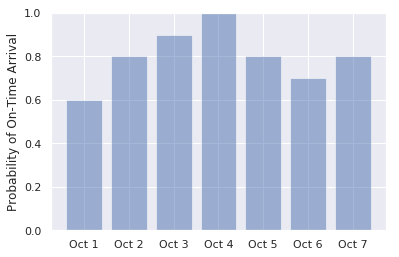

In [36]:
import numpy as np

labels = ('Oct 1', 'Oct 2', 'Oct 3', 'Oct 4', 'Oct 5', 'Oct 6', 'Oct 7')
values = (predict_delay('1/10/2018 13:00:00', 'JFK', 'MSP'),
          predict_delay('2/10/2018 13:00:00', 'JFK', 'MSP'),
          predict_delay('3/10/2018 13:00:00', 'JFK', 'MSP'),
          predict_delay('4/10/2018 13:00:00', 'JFK', 'MSP'),
          predict_delay('5/10/2018 13:00:00', 'JFK', 'MSP'),
          predict_delay('6/10/2018 13:00:00', 'JFK', 'MSP'),
          predict_delay('7/10/2018 13:00:00', 'JFK', 'MSP'))
alabels = np.arange(len(labels))

plt.bar(alabels, values, align='center', alpha=0.5)
plt.xticks(alabels, labels)
plt.ylabel('Probability of On-Time Arrival')
plt.ylim((0.0, 1.0))

Writing code to graph the probability that flights leaving SEA for ATL at 9:00 a.m., noon, 3:00 p.m., 6:00 p.m., and 9:00 p.m. on January 30 will arrive on time.

(0.0, 1.0)

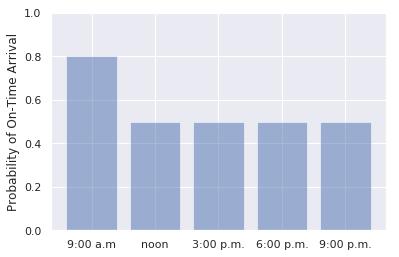

In [39]:
import numpy as np

labels = ('9:00 a.m', 'noon', '3:00 p.m.', '6:00 p.m.', '9:00 p.m.')
values = (predict_delay('30/01/2018 09:00:00', 'SEA', 'ATL'),
          predict_delay('30/01/2018 12:00:00', 'SEA', 'ATL'),
          predict_delay('30/01/2018 15:00:00', 'SEA', 'ATL'),
          predict_delay('30/01/2018 18:00:00', 'SEA', 'ATL'),
          predict_delay('30/01/2018 21:00:00', 'SEA', 'ATL'))
alabels = np.arange(len(labels))

plt.bar(alabels, values, align='center', alpha=0.5)
plt.xticks(alabels, labels)
plt.ylabel('Probability of On-Time Arrival')
plt.ylim((0.0, 1.0))

If you are new to Matplotlib and would like to learn more about it, you will find an excellent tutorial at https://www.labri.fr/perso/nrougier/teaching/matplotlib/. There is much more to Matplotlib than what was shown here, which is one reason why it is so popular in the Python community.

In this module, we learned how to:

Create a notebook in Azure Notebooks
Import data into a notebook using curl
Use Pandas to clean and prepare data
Use scikit-learn to build a machine-learning model
Use Matplotlib to visualize the results

Pandas, scikit-learn, and Matplotlib are among the most popular Python libraries on the planet. With them, you can prepare data for use in machine learning, build sophisticated machine-learning models from the data, and chart the output. Jupyter notebooks provide a ready-made environment for using these libraries, and Azure Notebooks give you easy access to Jupyter notebooks without requiring you to install any software or set up a Jupyter environment on a server.